In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy import signal
from PIL import Image
import argparse

# Copy the path of the folder that contains this notebook using the file navigation on the left:
# Ex. /content/drive/My\ Drive/CIS 581-Online/Canny Edge Project/Learner Code and Images/Code
sys.path.append('')

# import functions
from helpers import interp2

# Tests and Visualization

In [ ]:
def Test_script(I, E):
    test_pass = True

    # E should be 2D matrix
    if E.ndim != 2:
      print('ERROR: Incorrect Edge map dimension! \n')
      print(E.ndim)
      test_pass = False
    # end if

    # E should have same size with original image
    nr_I, nc_I = I.shape[0], I.shape[1]
    nr_E, nc_E = E.shape[0], E.shape[1]

    if nr_I != nr_E or nc_I != nc_E:
      print('ERROR: Edge map size has changed during operations! \n')
      test_pass = False
    # end if

    # E should be a binary matrix so that element should be either 1 or 0
    numEle = E.size
    numOnes, numZeros = E[E == 1].size, E[E == 0].size

    if numEle != (numOnes + numZeros):
      print('ERROR: Edge map is not binary one! \n')
      test_pass = False
    # end if

    if test_pass:
      print('Shape Test Passed! \n')
    else:
      print('Shape Test Failed! \n')

    return test_pass

In [ ]:
'''
  Derivatives visualzation function
'''
def visDerivatives(I_gray, Mag, Magx, Magy):
    fig, (Ax0, Ax1, Ax2, Ax3) = plt.subplots(1, 4, figsize = (20, 8))

    Ax0.imshow(Mag, cmap='gray', interpolation='nearest')
    Ax0.axis('off')
    Ax0.set_title('Gradient Magnitude')

    Ax1.imshow(Magx, cmap='gray', interpolation='nearest')
    Ax1.axis('off')
    Ax1.set_title('Gradient Magnitude (x axis)')
    
    Ax2.imshow(Magy, cmap='gray', interpolation='nearest')
    Ax2.axis('off')
    Ax2.set_title('Gradient Magnitude (y axis)')

    # plot gradient orientation
    Mag_vec = Mag.transpose().reshape(1, Mag.shape[0] * Mag.shape[1]) 
    hist, bin_edge = np.histogram(Mag_vec.transpose(), 100)

    ind_array = np.array(np.where( (np.cumsum(hist).astype(float) / hist.sum()) < 0.95))
    thr = bin_edge[ind_array[0, -1]]

    ind_remove = np.where(np.abs(Mag) < thr)
    Magx[ind_remove] = 0
    Magy[ind_remove] = 0

    X, Y = np.meshgrid(np.arange(0, Mag.shape[1], 1), np.arange(0, Mag.shape[0], 1))
    Ori = np.arctan2(Magy, Magx)
    ori = Ax3.imshow(Ori, cmap='hsv')
    Ax3.axis('off')
    Ax3.set_title('Gradient Orientation')
    fig.colorbar(ori, ax=Ax3, )
    


'''
  Edge detection result visualization function
'''
def visCannyEdge(Im_raw, M, E):
    # plot image
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 12))

    # plot original image
    ax0.imshow(Im_raw)
    ax0.axis("off")
    ax0.set_title('Raw image')

    # plot edge detection result
    ax1.imshow(M, cmap='gray', interpolation='nearest')
    ax1.axis("off")
    ax1.set_title('Non-Max Suppression Result')

    # plot original image
    ax2.imshow(E, cmap='gray', interpolation='nearest')
    ax2.axis("off") 
    ax2.set_title('Canny Edge Detection')

# Functions

In [ ]:
'''
  Convert RGB image to gray one manually
  - Input I_rgb: 3-dimensional rgb image
  - Output I_gray: 2-dimensional grayscale image
'''
def rgb2gray(I_rgb):
    r, g, b = I_rgb[:, :, 0], I_rgb[:, :, 1], I_rgb[:, :, 2]
    I_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return I_gray

In [ ]:
def findDerivatives(I_gray):
    '''
    File clarification:
        Compute gradient information of the input grayscale image
        - Input I_gray: H x W matrix as image
        - Output Mag: H x W matrix represents the magnitude of derivatives
        - Output Magx: H x W matrix represents the magnitude of derivatives along x-axis
        - Output Magy: H x W matrix represents the magnitude of derivatives along y-axis
        - Output Ori: H x W matrix represents the orientation of derivatives
    '''
    
    G = np.array([[2,4,5,4,2],[4,9,12,9,4],[5,12,15,12,5],[4,9,12,9,4],[2,4,5,4,2]])
    G = G/159 # Gaussian Blur
    dx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) # Vertical edge filter
    dy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) # Horizontal edge filter
    
    Gx = signal.convolve2d(G,dx,'same')
    Gy = signal.convolve2d(G,dy,'same')
    
    Magx = signal.convolve2d(I_gray,Gx,'same')
    Magy = signal.convolve2d(I_gray,Gy,'same')
    
    Mag = np.sqrt(Magx**2 + Magy**2)
    Ori = np.arctan2(Magy, Magx)
    
    return Mag, Magx, Magy, Ori

In [ ]:
## Test ##

# you may need to change the path to I1.jpg under Images folder
I = plt.imread('Images/I1.jpg')
Mag, Magx, Magy, Ori= findDerivatives(I)
assert np.allclose(Mag, np.load('Mag.npy'))
assert np.allclose(Magy, np.load('Magy.npy'))
assert np.allclose(Magx, np.load('Magx.npy'))

assert np.allclose(Ori, np.load('Ori.npy'))

In [ ]:
def nonMaxSup(Mag, Ori):
    '''
    File clarification:
        Find local maximum edge pixel using NMS along the line of the gradient
        - Input Mag: H x W matrix represents the magnitude of derivatives
        - Input Ori: H x W matrix represents the orientation of derivatives
        - Output M: H x W binary matrix represents the edge map after non-maximum suppression
    '''
    # getting neighcbor in the oritention direction
    nc, nr = Mag.shape[1], Mag.shape[0]


    #zero pad Mag and Ori
    Mag_pad = np.zeros((nr+2,nc+2))
    Mag_pad[1:-1,1:-1] =+ Mag

    Ori_pad = np.zeros((nr+2,nc+2))
    Ori_pad[1:-1,1:-1] =+ Ori

    x, y = np.meshgrid(np.arange(nc+2), np.arange(nr+2))

    # tranform x, y in the direction of the gradient
    x_next = x + np.cos(-Ori_pad) #-ve to account for ccw rotation
    y_next = y + np.sin(Ori_pad) #y is +ve as its inverted (y increases down)

    # use interp2 to get pixel values of the neighbors
    neighbor1 = interp2(Mag_pad, x_next, y_next) 

    # tranform x, y in the opposite direction of the gradient
    x_prev = x + np.cos(-Ori_pad + np.pi) #-ve to account for ccw rotation
    y_prev = y + np.sin(Ori_pad + np.pi) #y is +ve as its inverted (y increases down)

    # getting neighbor in the opposite of the orientation direction
    neighbor2 = interp2(Mag_pad, x_prev, y_prev)

    # perform NMS
    M_pad = np.array([(Mag_pad>neighbor1)* (Mag_pad>neighbor2)]).reshape(nr+2,nc+2)
    M = M_pad[1:-1,1:-1]
    
    return M
    


In [ ]:
## Test ##
Mag = np.array([[0, 2, 12, 16],
                [4, 9, 11, 8],
                [7, 17, 12, 9],
                [0, 19, 21, 17]])
Ori = np.array([[np.pi/2, np.pi/4, 0, np.pi/4],
                [np.pi/4, np.pi/4, np.pi/4, np.pi/2],
                [np.pi/4, 0, np.pi/2, np.pi/4],
                [np.pi/2, np.pi/4, np.pi/2, np.pi/4]])
res = np.array([[False, False, False,  True],
       [False, False,  True, False],
       [False,  True, False, False],
       [False,  True,  True,  True]])
M = nonMaxSup(Mag, Ori)
assert M.dtype == bool
assert M.shape == Mag.shape
assert np.allclose(M, res)

In [ ]:
def edgeLink(M, Mag, Ori, low, high):
    '''
    File clarification:
        Use hysteresis to link edges based on high and low magnitude thresholds
        - Input M: H x W logical map after non-max suppression
        - Input Mag: H x W matrix represents the magnitude of gradient
        - Input Ori: H x W matrix represents the orientation of gradient
        - Input low, high: low and high thresholds 
        - Output E: H x W binary matrix represents the final canny edge detection map
    '''

    # #Normalize Mag to scale values between 0 and 1
    # Mag = Mag/np.max(Mag)

    #Zero pad the arrays Mag, Ori, M
    nc, nr = Mag.shape[1], Mag.shape[0]
    Mag_pad = np.zeros((nr+2,nc+2))
    Mag_pad[1:-1,1:-1] =+ Mag

    #Getting edge orient
    Ori_edge = np.pi/2 + Ori
    #     Ori = -np.pi/2 + Ori
    Ori_pad = np.zeros((nr+2,nc+2))
    Ori_pad[1:-1,1:-1] =+ Ori_edge

    M_pad = np.zeros((nr+2, nc+2), dtype=bool)
    M_pad[1:-1, 1:-1] = M

    # print(Mag_pad)
    #Setting all non-NMS nodes to zero in Mag Pad
    Mag_pad = Mag_pad*M_pad
    # print(Mag_pad)

    #Suppress pixels whose magnitude is lower than low threshold
    z = np.zeros(Mag_pad.shape)
    Mag_pad = np.where(Mag_pad >= low, Mag_pad, z)
    #print(Mag_pad)

    #Initial EdgeMap with strong edges
    strong_edges = Mag_pad >= high #Strong edges must be in NMS and >= threshold
    strong_edgemag = np.where(strong_edges, Mag_pad,0) #Magnitude of points where a strong edge is present

    # print(strong_edges)
    # print(strong_edgemag)


    #Identify uncertain edges boolean map
    """ In between threshold pixel"""
    weak_edges = np.logical_and(Mag_pad >= low, Mag_pad < high)
    weak_edgemag = np.where(weak_edges, Mag_pad, 0) #Magnitude of points where a weak edge is present

    # print(weak_edges)
    # print(weak_edgemag)


    #Find neighbors in the edge direction
    x, y = np.meshgrid(np.arange(nc+2), np.arange(nr+2))


    #Tranform x, y in the direction of the gradient
    x_next = x + np.cos(-Ori_pad) #-ve to account for ccw rotation
    y_next = y + np.sin(Ori_pad) #y is +ve as its inverted (y increases down)

     #Tranform x, y in the opposite direction of the gradient
    x_prev = x + np.cos(-Ori_pad + np.pi) #-ve to account for ccw rotation
    y_prev = y + np.sin(Ori_pad + np.pi) #y is +ve as its inverted (y increases down)


    all_edges = strong_edges
    # print(x_next)
    done = False
    i = 1
    while not done:
        #Logging
    #         print("Iteration", i)
        i = i + 1

        #Get the neighbors
        neighbor1 = interp2(Mag_pad, x_next, y_next) 
        neighbor2 = interp2(Mag_pad, x_prev, y_prev)

    #     print(neighbor1)
    #     print(neighbor2)

        #retaining only weak edge neighbours
        neighbor1 = neighbor1*weak_edges
        neighbor2 = neighbor2*weak_edges

    #     print(neighbor1)
    #     print(neighbor2)

        #Check if the weak edge has and strong edges near them
        nearStrongPoints = np.logical_or(neighbor1 >= high, neighbor2 >= high)

        #print(nearStrongPoints)

        #find the max values form the neighbours
        neighbour_max = np.maximum(neighbor1,neighbor2)

        #Now we update these neighbors to the Magnitude matrix
        Mag_pad = Mag_pad*(~nearStrongPoints) + neighbour_max*(nearStrongPoints)

        #And Add them  to the all edge map
        all_edges = all_edges + nearStrongPoints

        #Remove them from the weak edge map so they dont need to be checked
        weak_edges = weak_edges*(~nearStrongPoints)


        if(not nearStrongPoints.any()):
            done = True
    
    all_edges_nopad = all_edges[1:-1,1:-1]

    return all_edges_nopad

In [ ]:
## Test ##
M = np.array([[True, False, True,  True],
              [False, True,  True, True],
              [True,  True, False, False],
              [False,  True,  True,  True]])
Mag = np.array([[12, 9, 14, 16],
                [4, 11, 40, 18],
                [13, 12, 30, 15],
                [28, 15, 21, 8]])
Ori = np.array([[np.pi/2, np.pi/4, 0, np.pi/4],
                [np.pi/4, np.pi/4, np.pi/4, np.pi/2],
                [np.pi/4, 0, np.pi/2, np.pi/4],
                [np.pi/2, np.pi/4, np.pi/2, np.pi/4]])
res = np.array([[False, False,  True,  True],
       [False,  True,  True,  True],
       [ True,  True, False, False],
       [False, False,  True, False]])
low, high = 10, 20
E = edgeLink(M, Mag, Ori, low, high)
assert E.dtype == bool
assert E.shape == Mag.shape
assert np.allclose(E, res)

In [82]:
def cannyEdge(I, low, high):
    # convert RGB image to gray color space
    im_gray = rgb2gray(I)

    Mag, Magx, Magy, Ori = findDerivatives(im_gray)
    M = nonMaxSup(Mag, Ori)
    E = edgeLink(M, Mag, Ori, low, high)
    
    plt.hist(Mag*M, bins=10)
    print("20 per", np.percentile(Mag,20))
    print("80 per", np.percentile(Mag,80))
    
    #print(Mag)
    # only when test passed that can show all results
    if Test_script(im_gray, E):
        # visualization results
        visDerivatives(im_gray, Mag, Magx, Magy)
        visCannyEdge(I, M, E)

        plt.show()

    return E

## Simple image test cases
First, let's try to detect edges in two simple images.

![checkerboard.jpg](Test_Images/rotated_checkerboard.jpg)

For the rotated checkerboard, We should be able to get edges in both directions.

![checkerboard_res.jpg](Test_Images/rotated_checkerboard_Result.png)

![coins.png](Test_Images/coins.png) 

For coins, we should be able to detect circles.

![coins.png](Test_Images/coins_Result.png) 

Testing Edge Detection

20 per 1.8174261258406503
80 per 53.07044128513101
Shape Test Passed! 



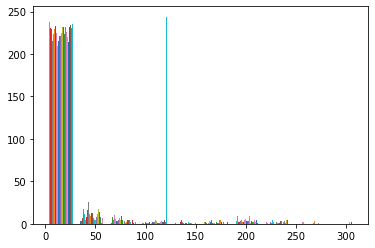

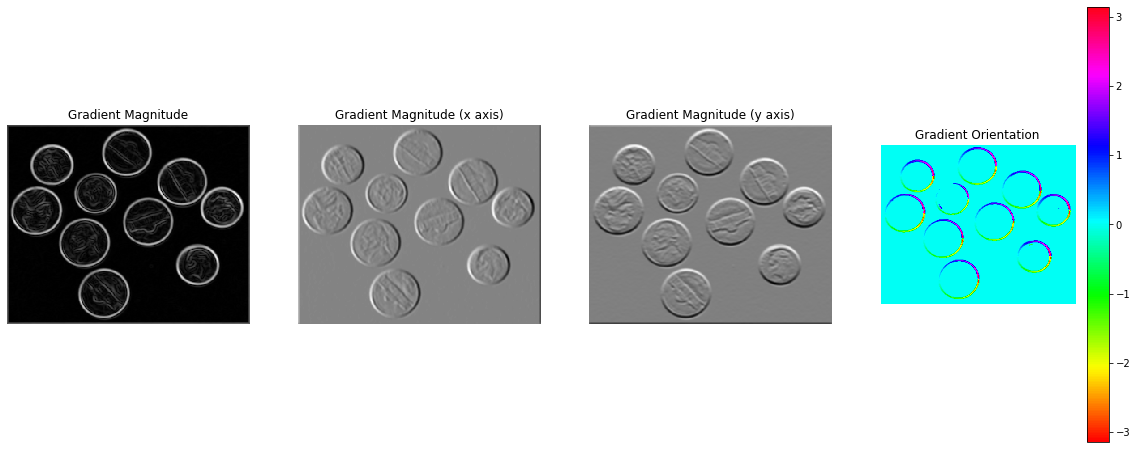

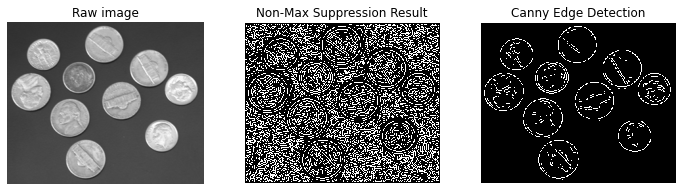

In [75]:
# tuning threshold for simple test images
image_folder = "Test_Images"
save_folder = "Results" # need to create this folder in the drive
filename='coins.png' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high = 2, 53
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

## Tune the threshold for each images under "Image" folder

20 per 0.8071760948851344
80 per 2.209108384080894
Shape Test Passed! 



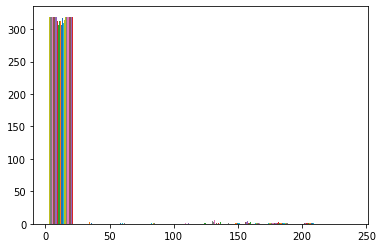

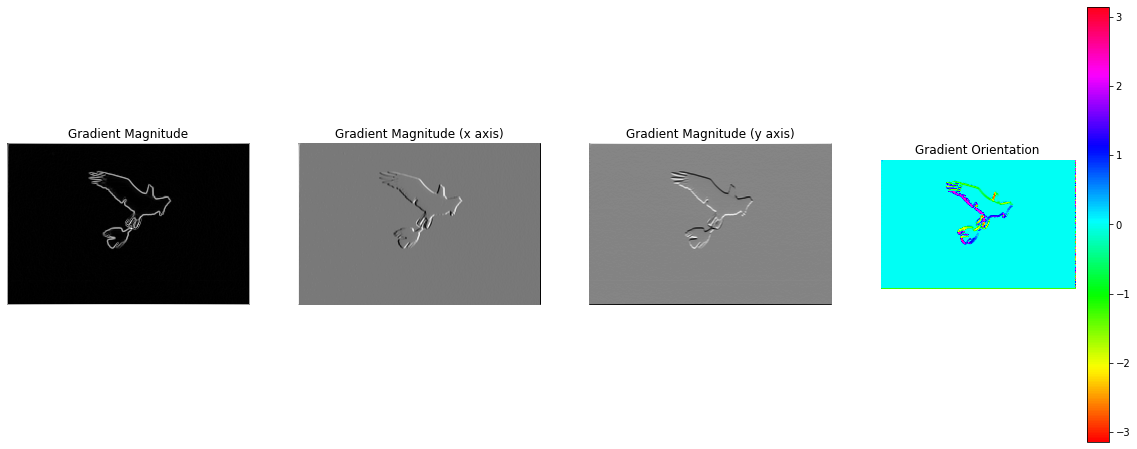

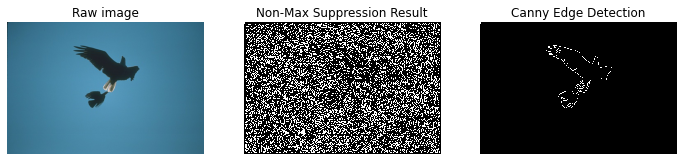

In [178]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='135069.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high =  1,19
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

20 per 4.050716828981883e-14
80 per 2.4551957366261985
Shape Test Passed! 



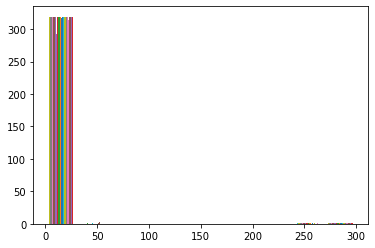

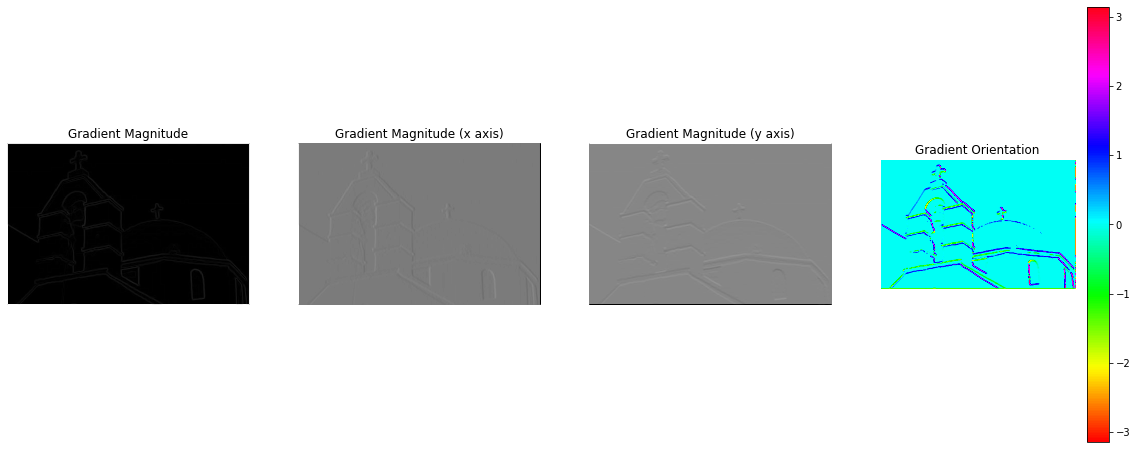

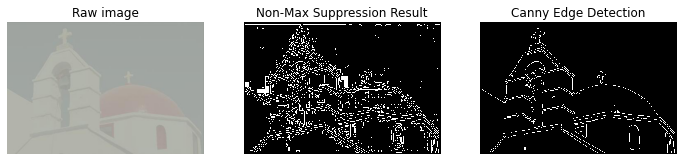

In [85]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='118035.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high = 1,6
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

# Fill in all tuned threshold to generate edge detection results


In [ ]:
# keep results for all images
image_folder = "Images"
save_folder = "Results"
# fill in the threshold (low, high) you have tuned in the cell above 
thresh_dict = {'118035.jpg': (0, 0),
                '135069.jpg': (0, 0),
                '16068.jpg': (0, 0),
                '189080.jpg': (0, 0),
                '201080.jpg': (0, 0),
                '21077.jpg': (0, 0),
                '22013.jpg': (0, 0),
                '3096.jpg': (0, 0),
                '48017.jpg': (0, 0),
                '55067.jpg': (0, 0),
                '86000.jpg': (0, 0),
                'I1.jpg': (0, 0)}
# generate results one by one
for filename in os.listdir(image_folder):
    # read in image 
    im_path = os.path.join(image_folder, filename)
    I = np.array(Image.open(im_path).convert('RGB'))

    low, high = thresh_dict[filename]
    E = cannyEdge(I, low, high)

    pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')

    pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

20 per 9.126192144081934
80 per 69.17215359871444
Shape Test Passed! 



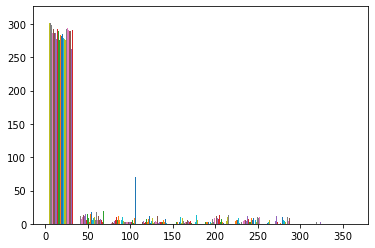

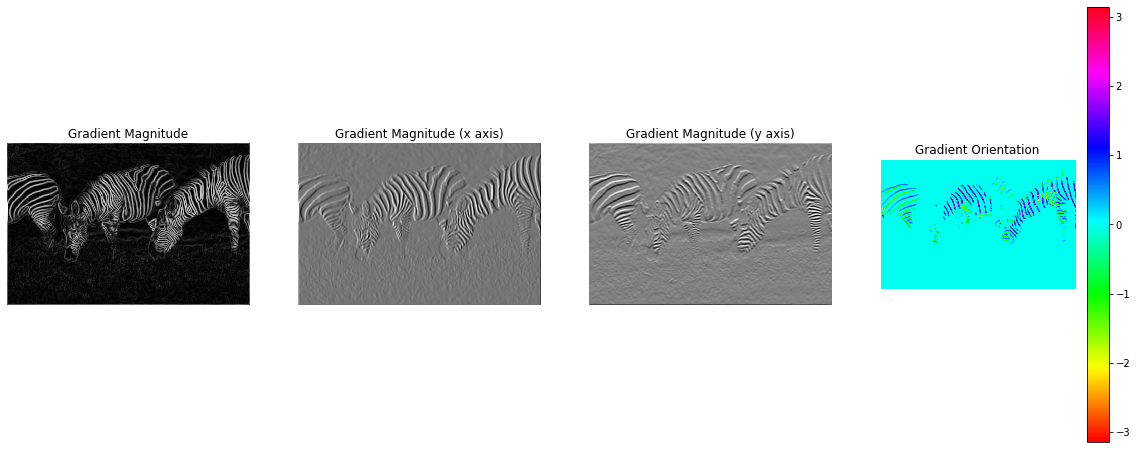

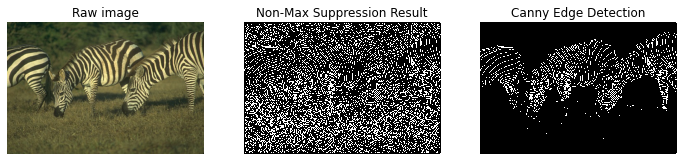

In [99]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='16068.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high =  10,65
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

20 per 2.226290947073678
80 per 63.676782647711036
Shape Test Passed! 



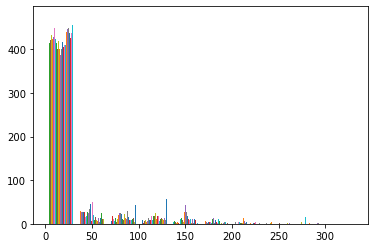

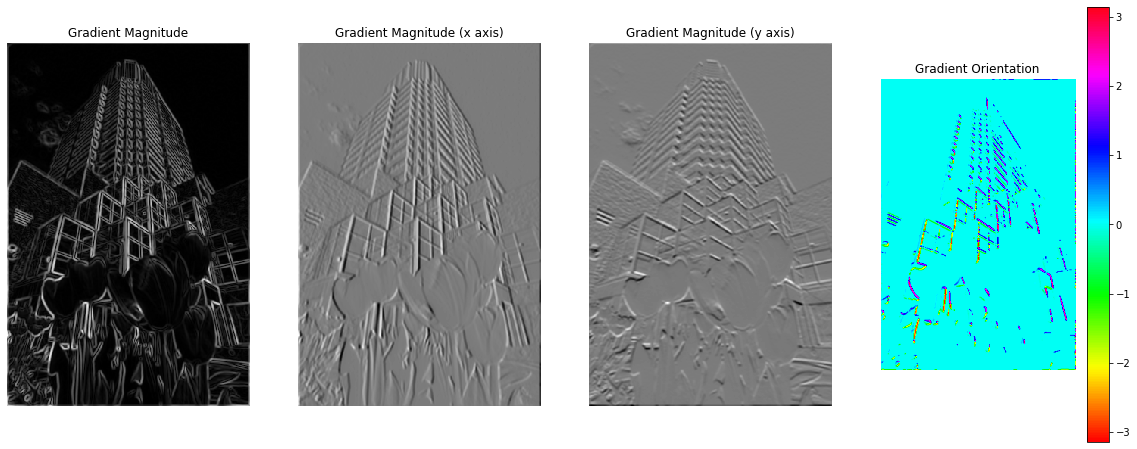

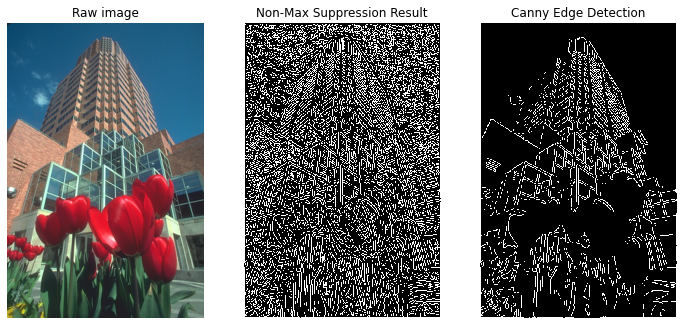

In [184]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='86000.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high =  2,60
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

20 per 1.1936347773691856
80 per 4.775017793382525
Shape Test Passed! 



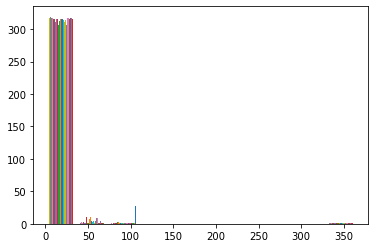

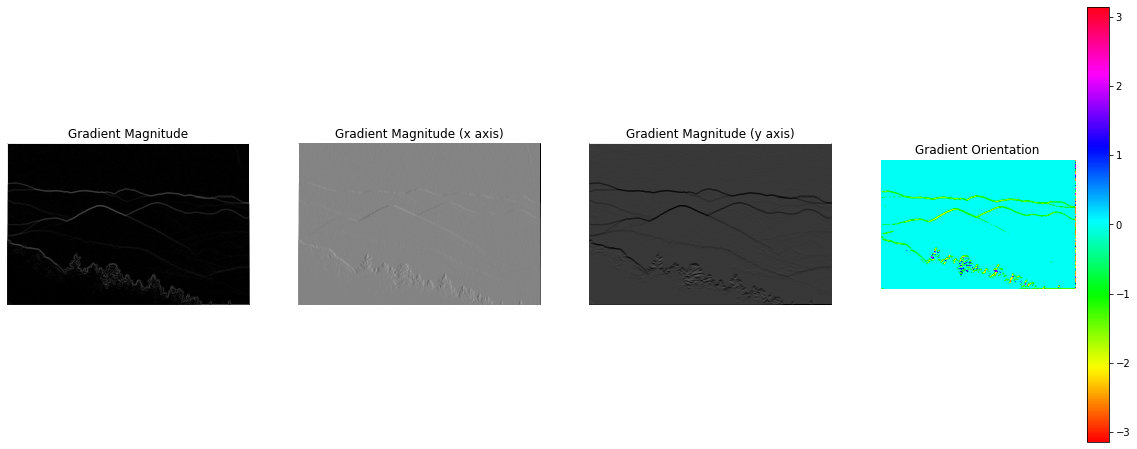

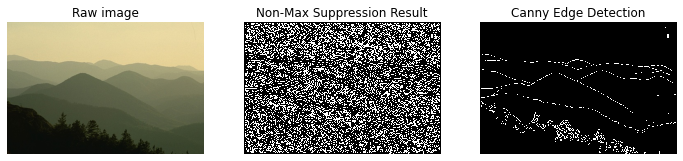

In [183]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='55067.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high =  1,11
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

20 per 5.634987984825573
80 per 76.74745012124018
Shape Test Passed! 



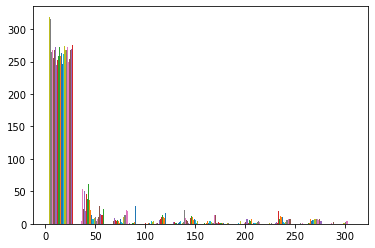

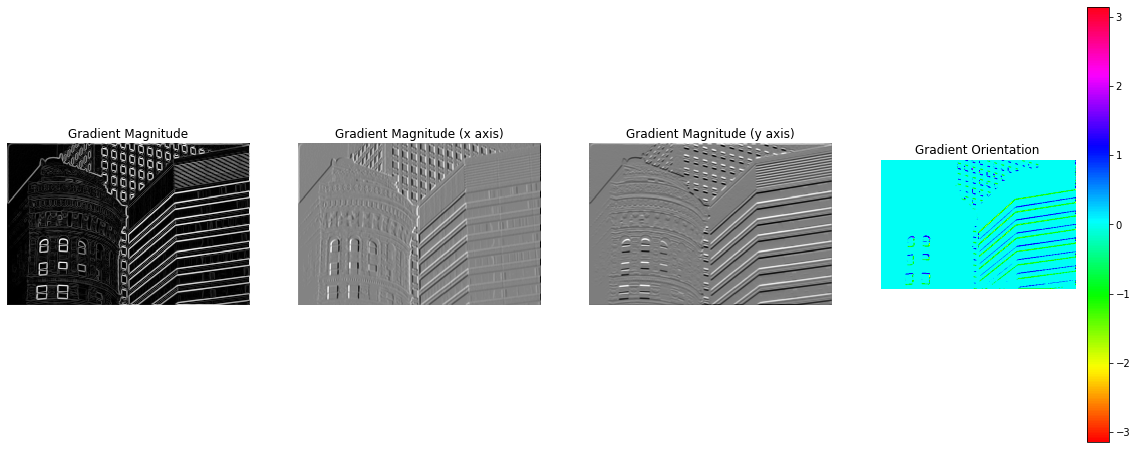

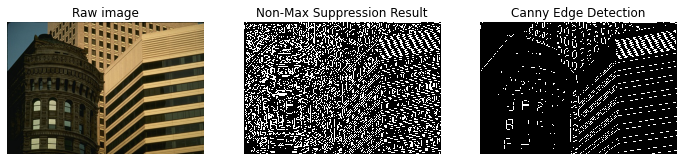

In [122]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='48017.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high =  1,70
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

20 per 1.6280853687786931
80 per 6.371306492377134
Shape Test Passed! 



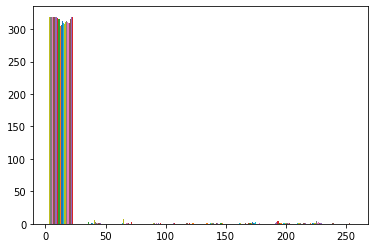

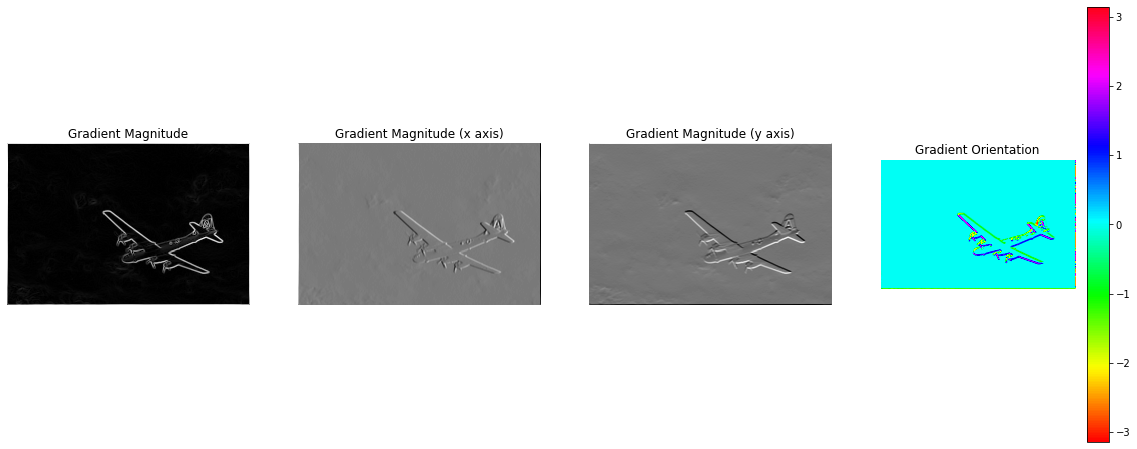

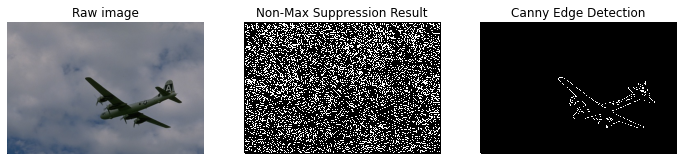

In [182]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='3096.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high =  5,38
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

20 per 0.0
80 per 7.640399661428379e-14
Shape Test Passed! 



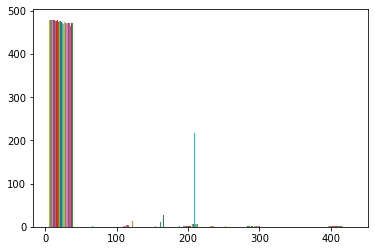

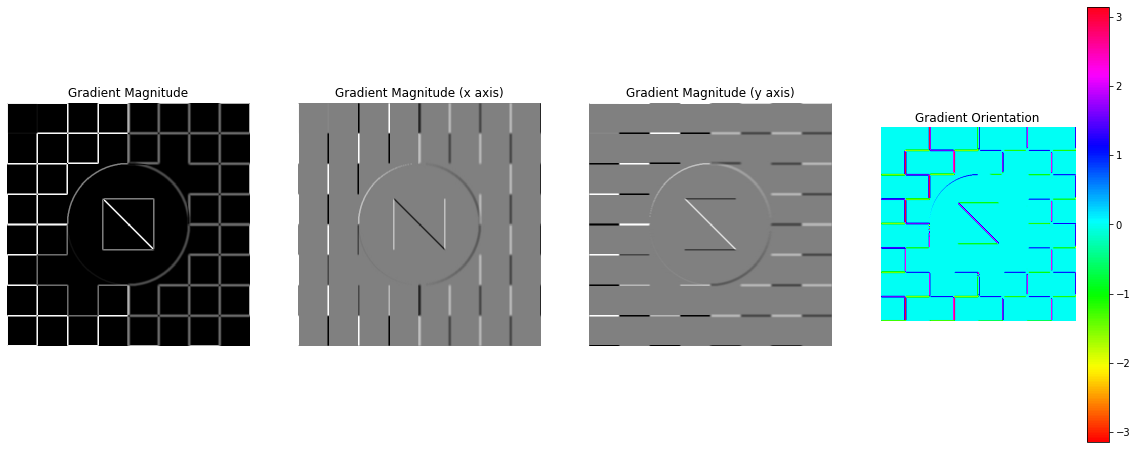

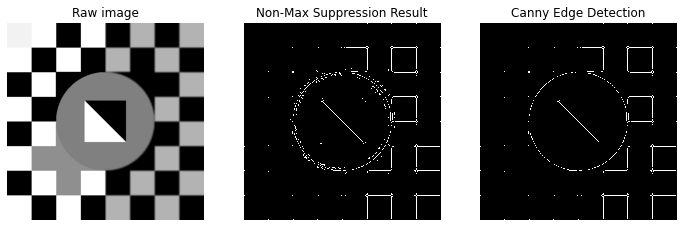

In [146]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='I1.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high =  0.0001,3
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

20 per 2.4432132073620347
80 per 52.64509263638668
Shape Test Passed! 



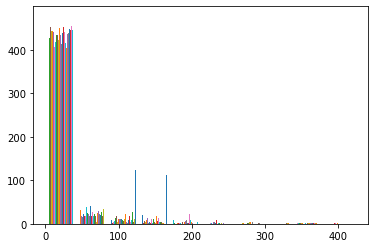

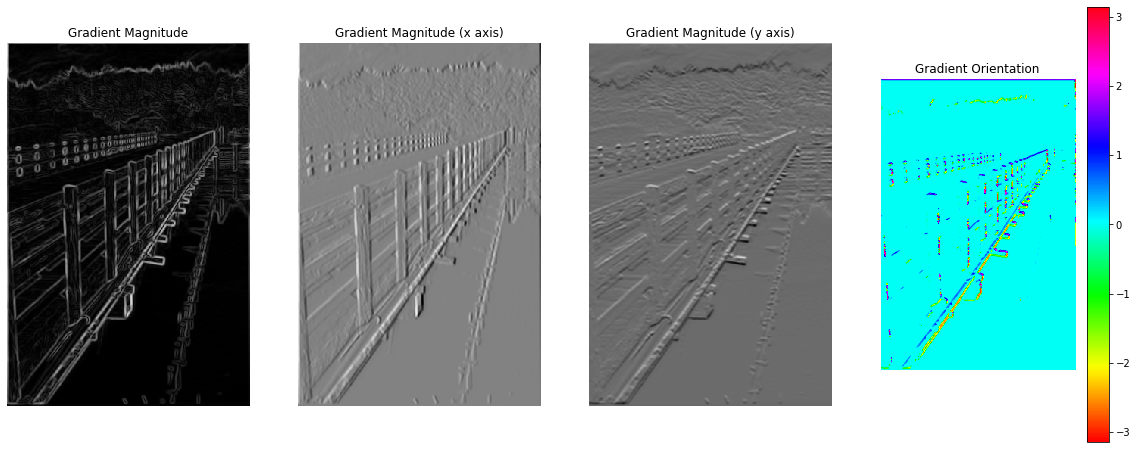

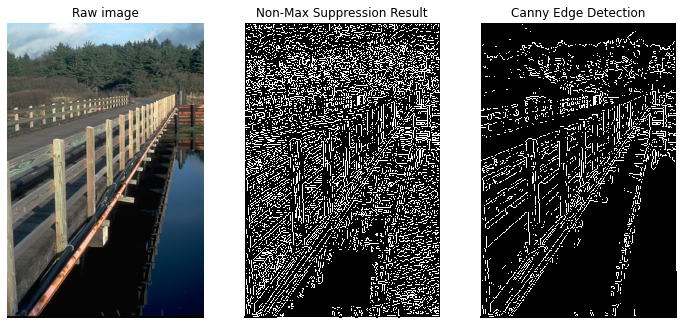

In [153]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='22013.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high =  0.1,39
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

20 per 5.317489098657976
80 per 53.387501266089345
Shape Test Passed! 



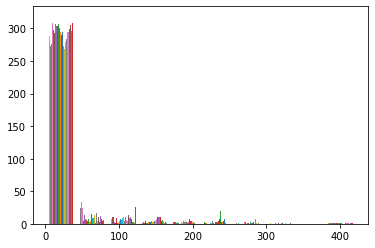

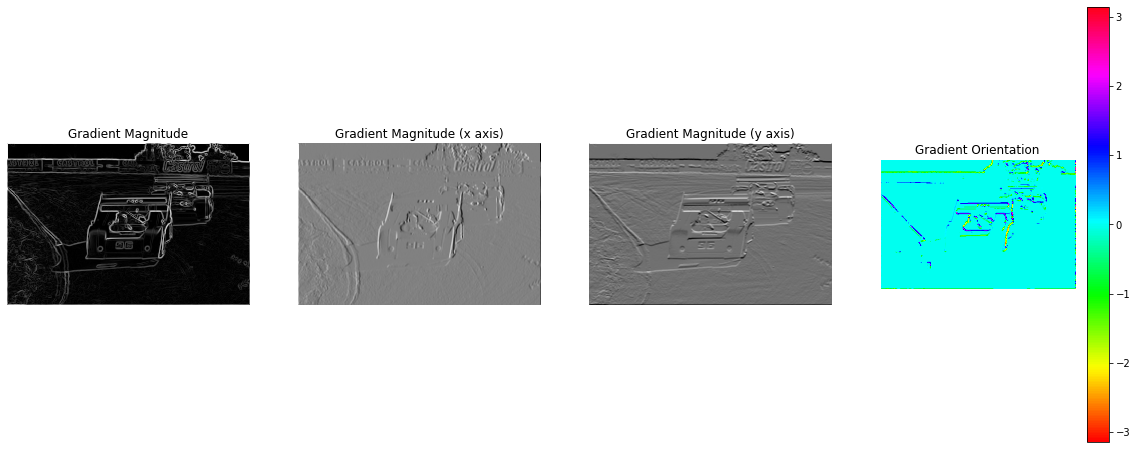

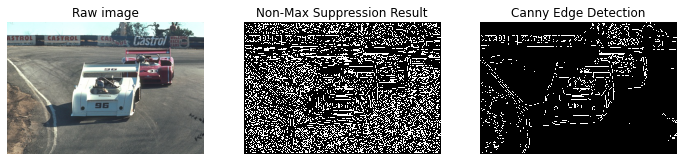

In [160]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='21077.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high =  10,57
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

20 per 1.692738176170308
80 per 32.65244203698048
Shape Test Passed! 



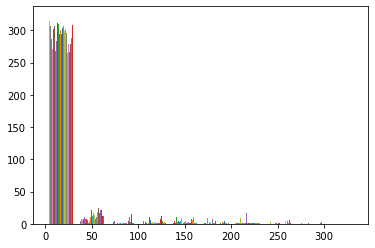

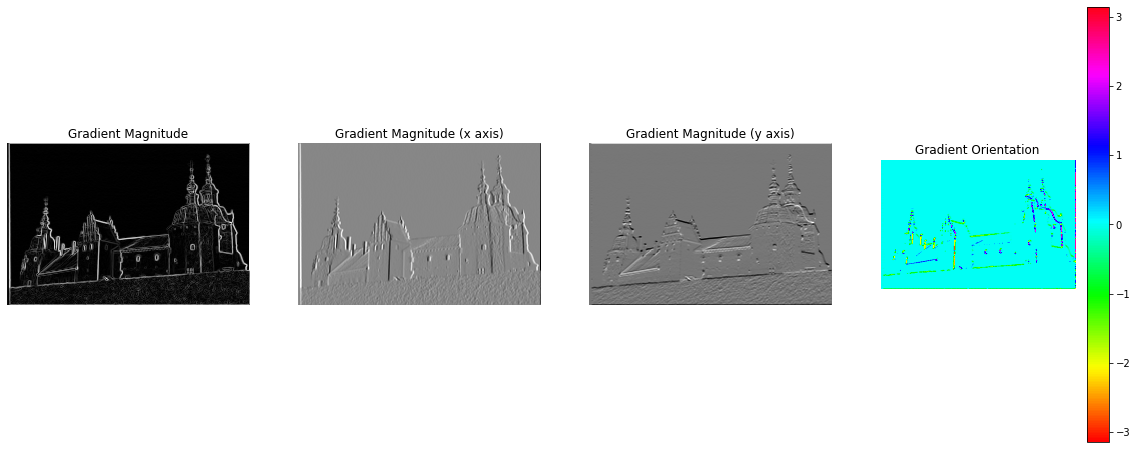

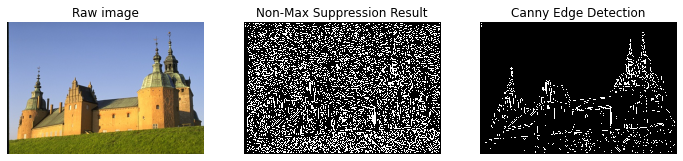

In [166]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='201080.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high =  0.0001,45
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

20 per 2.6157613696268966
80 per 25.662806409027663
Shape Test Passed! 



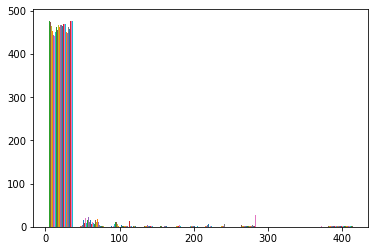

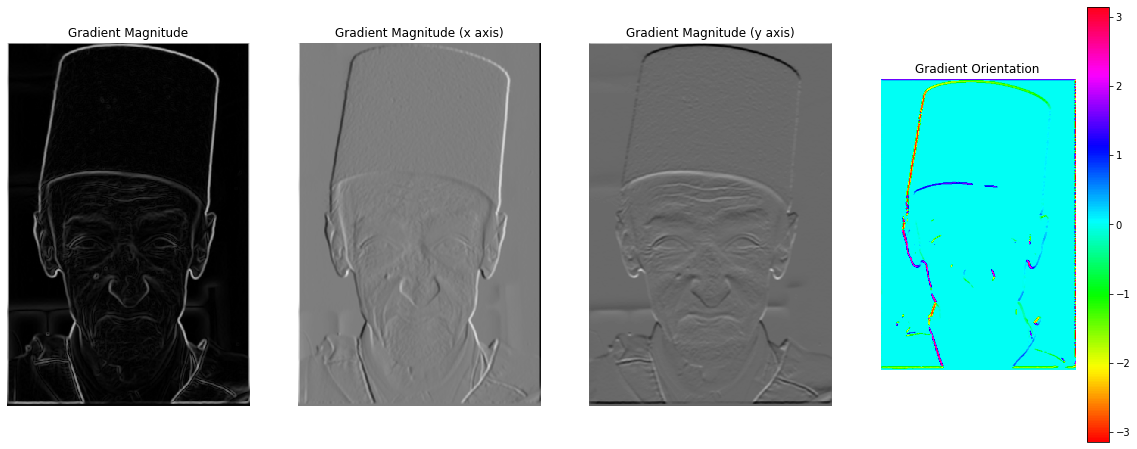

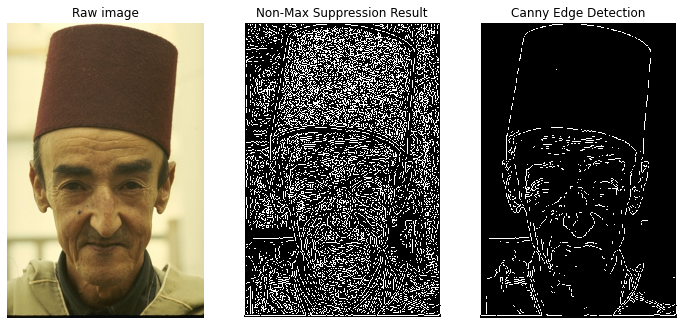

In [177]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='189080.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high =  5,35
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))